## Семинар 2 "Распознавание рукописных цифр"

ФИО: Перфильева Нелли Андреевна

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

/opt/conda/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

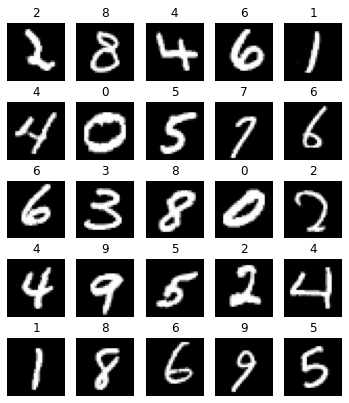

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [4]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 19... (Train/Test) NLL: 0.309/0.300	Accuracy: 0.920/0.921

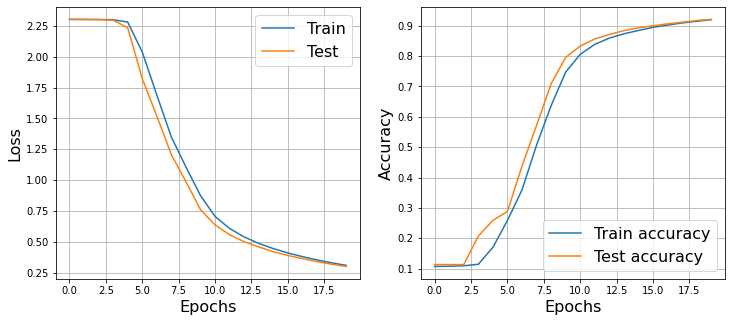

In [9]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [5]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.036/0.079	Accuracy: 0.990/0.976

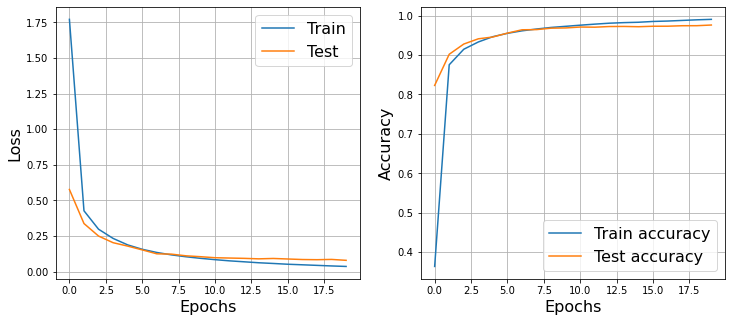

In [14]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

In [6]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.046/0.078	Accuracy: 0.987/0.976

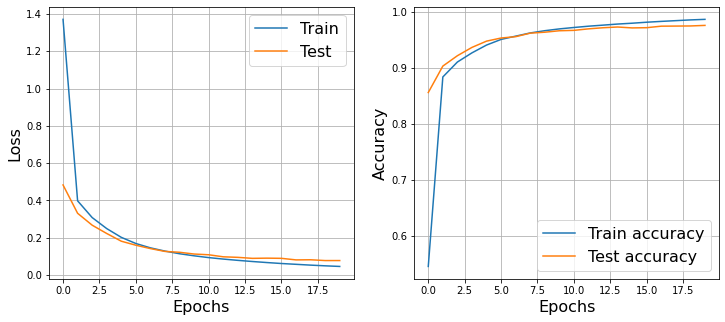

In [15]:
network = NeuralNetwork([
    Linear(784, 100), ELU(),
    Linear(100, 100), ELU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

Сравнение сигмоиды, RELU, ELU

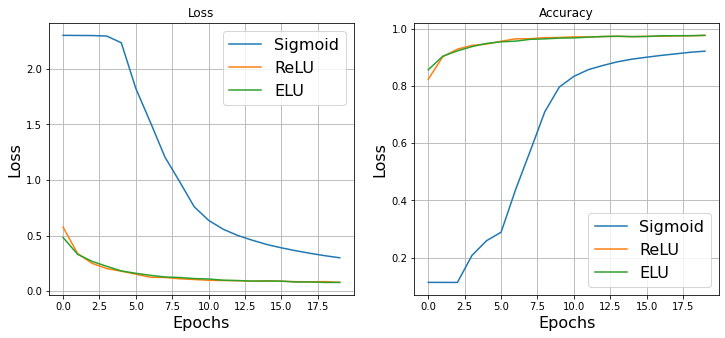

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [12]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

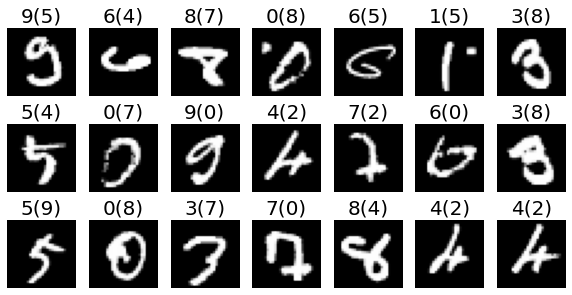

In [13]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

В основном ошибочные объекты (5, 9), (3, 8), (1, 7), но некоторые из них действительно сложно распознать

### HW1 (1 балл): Реализовать Tanh

$$y = th(x) = \frac {e^x - e^{-x}} {e^x + e^{-x}}$$
$$y' = 1 - y^2$$

In [22]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.Y = np.tanh(X)
        return self.Y

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * (1 - self.Y ** 2)

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.030/0.080	Accuracy: 0.994/0.976

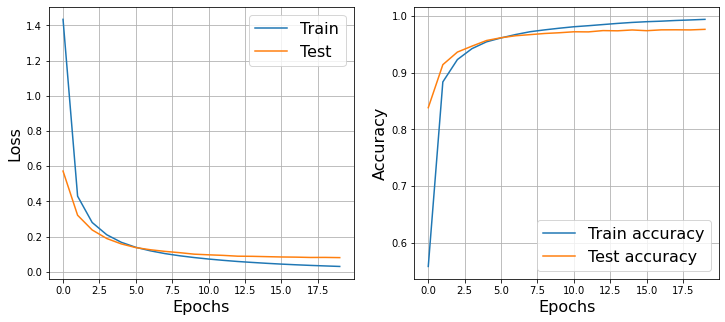

In [15]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Tanh дает такую же точность по сравнению с RELU на тесте

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

ВРАЩЕНИЕ

In [16]:
train_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                       transforms.RandomRotation(degrees = (-15, 15))
                    ])
test_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=train_transform)
test_dataset = MNIST('.', train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.065/0.064	Accuracy: 0.981/0.981

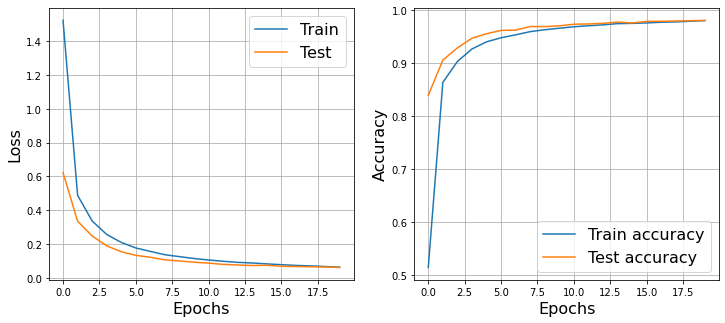

In [17]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Добавление вращения поспособствовало падению лосса и увеличению точности

In [18]:
train_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                       transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2))
                    ])
test_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=train_transform)
test_dataset = MNIST('.', train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.231/0.186	Accuracy: 0.927/0.944

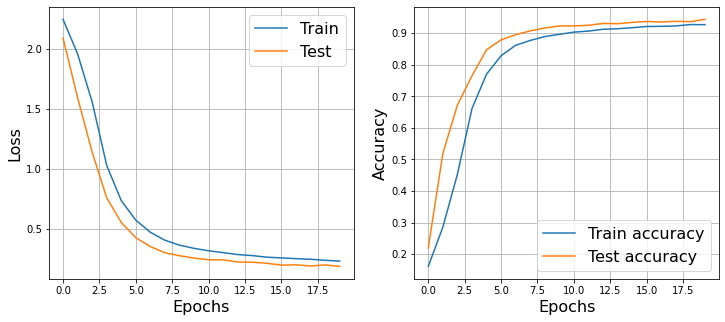

In [19]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
translate_tr_r, translate_ts_r, translate_tr_ac_r, translate_ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Лосс значительно вырос, точность упала по сравнию с предсказанием без применения аугментации в виде сдвига

In [24]:
from torch import randn

In [18]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Epoch 19... (Train/Test) NLL: 0.095/0.071	Accuracy: 0.969/0.978

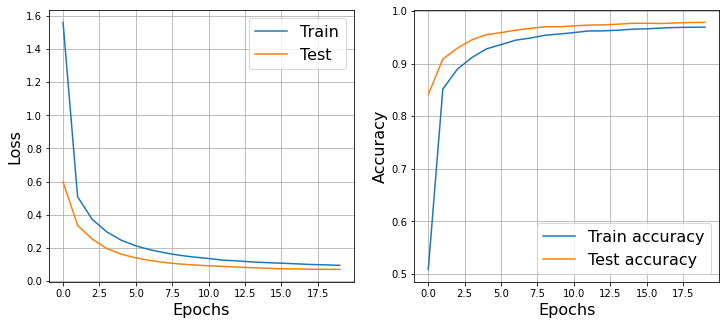

In [22]:
train_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                       AddGaussianNoise(0, 1.)])
test_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=train_transform)
test_dataset = MNIST('.', train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
noise_tr_r, noise_ts_r, noise_tr_ac_r, noise_ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Добавление шумов тоже вполне себе применимо - точность даже улучшилась

Попробуем сделать композицию агументаций

После включения всех трех параметров получился очень плохой результат- лосс около 0.2, точность тоже низкая.
Попробовала включить только поворт и шум- дало в принципе неплохой результат, однако с одним вращением было немного лучше. 

Epoch 19... (Train/Test) NLL: 0.132/0.068	Accuracy: 0.959/0.979

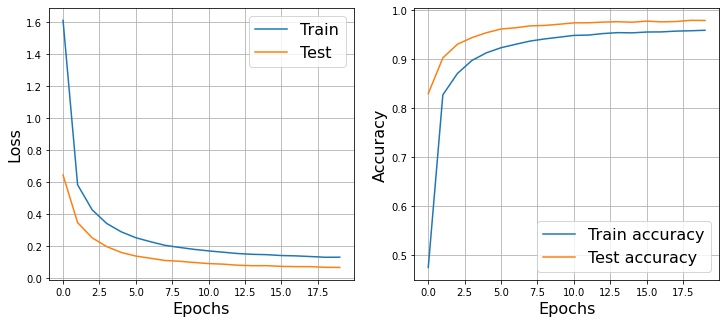

In [25]:
train_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                       transforms.RandomAffine(degrees=15),
                       AddGaussianNoise(0, 1.)
])
test_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=train_transform)
test_dataset = MNIST('.', train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
mixed_tanh_tr_r, mixed_tanh_ts_r, mixed_tanh_tr_ac_r, mixed_tanh_ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

Epoch 19... (Train/Test) NLL: 0.233/0.075	Accuracy: 0.925/0.977

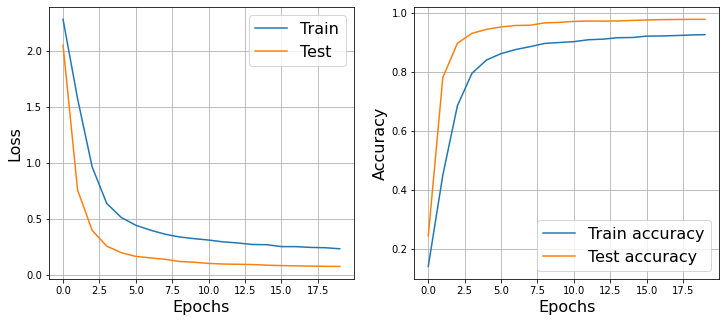

In [24]:
train_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                       AddGaussianNoise(0, 1.), 
                       transforms.RandomRotation(degrees = (-15, 15)), 
#                        transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1))
])
test_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=train_transform)
test_dataset = MNIST('.', train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
mixed_relu_tr_r, mixed_relu_ts_r, mixed_relu_tr_ac_r, mixed_relu_ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.070/0.076	Accuracy: 0.979/0.977

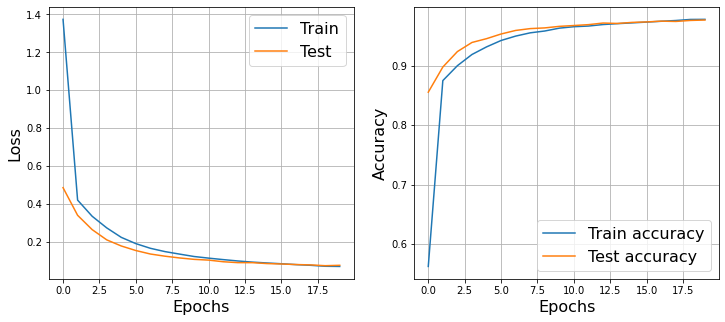

In [25]:
train_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                       AddGaussianNoise(0, 0.5), 
                       transforms.RandomRotation(degrees = (-5, 5)), 
#                        transforms.RandomAffine(degrees = 0, translate = (0.01, 0.01))
])
test_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), 
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=train_transform)
test_dataset = MNIST('.', train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

network = NeuralNetwork([
    Linear(784, 100), ELU(),
    Linear(100, 100), ELU(),
    Linear(100, 10)
])
loss = NLLLoss()
mixed_elu_tr_r, mixed_elu_ts_r, mixed_elu_tr_ac_r, mixed_elu_ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Промежуточные выводы были описаны после применения каждого из методов

Обобщим:

В отличие от нелинейностей сигмоида показала худший результат как в оценке лосса, так и в точности. 
Что касаемо скорости сходимости - из графика видно, что сигмоида сильно уступает ReLU ELU в сходимости


Добавление агументации в виде вращения увеличило качество предсказания, тот же самый эффект достигло при добавлении шумов, а вот случайные сдвиги наоборот - лишь ухудшили качество предсказания


При взятии композиции данных преобразований итоговое качество ухудшилось. Особенно если взять все три варианта вместе. Композиция из шума и вращения дает неплохой результат. Тем не менее, добавление одного вращения показало лучшее качество